In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 1 : Loading Dataset (NEU Steel Defect Classification Dataset from Drive)
It contains training,testing and validation images in separate folder namely (train/test/valid).
In this dataset there are 6 class classification namely
1) Crazing - Fine interconnected cracks on surface os steel
2) Inclusion - some foreign partciles present on the suraface of the steel
3) Patches - Irregular area of dicoloration / roughness
4) Rolled - Oxide scale on steel surface
5) Pit - small hole in surface
6) Scratches - Marks/ abrasion on the surface of steel
This code section will show number of images under each folder based on the class.

In [3]:
import os

base_dir = '/content/drive/MyDrive/NEU_Steel_Defect_Dataset'  # Adjust if needed
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')  # Or 'val' if that's your name
test_dir = os.path.join(base_dir, 'test')

classes = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

print("Train samples per class:")
for cls in classes:
    print(f"  {cls}: {len(os.listdir(os.path.join(train_dir, cls)))}")

print("\nValid samples per class:")
for cls in classes:
    print(f"  {cls}: {len(os.listdir(os.path.join(valid_dir, cls)))}")

print("\nTest samples per class:")
for cls in classes:
    print(f"  {cls}: {len(os.listdir(os.path.join(test_dir, cls)))}")

Train samples per class:
  Crazing: 276
  Inclusion: 276
  Patches: 276
  Pitted: 276
  Rolled: 276
  Scratches: 276

Valid samples per class:
  Crazing: 12
  Inclusion: 12
  Patches: 12
  Pitted: 12
  Rolled: 12
  Scratches: 12

Test samples per class:
  Crazing: 12
  Inclusion: 12
  Patches: 12
  Pitted: 12
  Rolled: 12
  Scratches: 12


Step 2 : Data preprocessing and Augmentation

The images in the dataset are gray scaled.(200,200)
But the pretrained Resnet-50 is trained for RGB images(224,224,3)
So the Gray scale images are converted to meet the requirements of Resnet-50.

Normalization : The pixels are rescales ( from : 0-255 to : 0 -1)

Augmenation have to be done in Training set only. It should not be done on testing or validation set.

Augmentation will increase the size of the training data.

It improves performance by not let the system to learn crack position in training image, instead it help the system to identify cracks regardless of where it is located or how it looks, in this way augmentation plays a key role.

The augmentaion techniques used here are rotating image, horizontal shifting, vertical shifting, image flipping and either zoom in or zoom out.

The Class label are represented as numbers,
Class indices: {'Crazing': 0, 'Inclusion': 1, 'Patches': 2, 'Pitted': 3, 'Rolled': 4, 'Scratches': 5}


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Parameters (same as before)
IMG_SIZE = 224
BATCH_SIZE = 32  # Adjust to 16 if GPU memory is low
NUM_CLASSES = 6

# Data generators
# Train: With augmentation for better generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize to [0,1]
    rotation_range=20,      # Slight rotations (±20°)
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2, # Vertical shifts
    horizontal_flip=True,   # Mirror images (defects can appear flipped)
    zoom_range=0.2,         # Zoom in/out
    fill_mode='nearest'     # Fill empty pixels after transforms
)

# Valid/Test: No augmentation—just normalization for clean eval
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Paths (updated for your folders)
base_dir = '/content/drive/MyDrive/NEU_Steel_Defect_Dataset'  # Adjust if different
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')  # Change to 'val' if that's your folder name
test_dir = os.path.join(base_dir, 'test')

# Load generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # One-hot labels for multi-class
    color_mode='rgb'           # Duplicate grayscale to 3 channels for ResNet
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False  # Keep order for accurate eval
)

# Verify class mapping (should match your folder names)
print("Class indices:", train_generator.class_indices)
print(f"Found {train_generator.samples} train images across {NUM_CLASSES} classes")

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Class indices: {'Crazing': 0, 'Inclusion': 1, 'Patches': 2, 'Pitted': 3, 'Rolled': 4, 'Scratches': 5}
Found 1656 train images across 6 classes


Step 4 : Building the Resnet 50 model

Transfer Learning Plays a key role here.
We use pretrained Resnet 50 for Steel defect classification. Lets see how we achieve that.

Transfer Learning Phase:

1) Loads pretrained model
2) Remove its original classification Layer
3) Add custom classification
4) Compile model for training

The pretrained weights are loaded and include_top = False will remove the final claasification layer in the pretrained model.

The base_model.trainable = False will freeze base layer, there is no need to re train the base layer, because the base layer is responsible for basic feature extraction like edge detection which is same for any calssification task. So there is no need the retrain that layer.



In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load pre-trained ResNet-50 (no top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base layers initially
base_model.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces spatial dims to 1x1
x = Dense(256, activation='relu')(x)  # Hidden layer for complexity
x = Dropout(0.5)(x)  # Regularization to prevent overfitting
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Output probs

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(
    optimizer='adam',  # Adaptive optimizer for fast convergence
    loss='categorical_crossentropy',  # For multi-class
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Step 5 : Training Resnet 50 for Steel Defect Classification

Early Stopping : Stops training if the validaltion loss does not improve for 5 epochs.

Model Checkpoint : Saves the model whenever the validation loss improves

Reduce Learning Rate : Reduce learning rate by 5 times if the model stops improving

In first training, only the newly added layers are trained and the base layer is stil frozen

In fine tuning phase, Last 20 layers are unfrozen and trained, but the early layers are stll remains froze.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop if no improvement
    ModelCheckpoint('/content/drive/MyDrive/NEU_dataset/best_model.h5', save_best_only=True),  # Save best
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

# Initial training (frozen base)
history = model.fit(
    train_generator,
    epochs=20,  # Start small; increase if needed
    validation_data=valid_generator,
    callbacks=callbacks
)

# Fine-tune: Unfreeze top layers
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all but last 20 layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1651 - loss: 2.0898 

52/52 ━━━━━━━━━━━━━━━━━━━━ 706s 13s/step - accuracy: 0.1650 - loss: 2.0869 - val_accuracy: 0.3194 - val_loss: 1.7746 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.1695 - loss: 1.7985

52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 516ms/step - accuracy: 0.1694 - loss: 1.7985 - val_accuracy: 0.1667 - val_loss: 1.7610 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.2103 - loss: 1.7775

52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 534ms/step - accuracy: 0.2103 - loss: 1.7775 - val_accuracy: 0.2778 - val_loss: 1.7584 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.2116 - loss: 1.7681

52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 530ms/step - accuracy: 0.2118 - loss: 1.7680 - val_accuracy: 0.2778 - val_loss: 1.7350 - learning_rate: 0.0010
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.2266 - loss: 1.7492

52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 530ms/step - accuracy: 0.2267 - loss: 1.7491 - val_accuracy: 0.5556 - val_loss: 1.7167 - learning_rate: 0.0010
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.2559 - loss: 1.7298

52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 540ms/step - accuracy: 0.2557 - loss: 1.7298 - val_accuracy: 0.3194 - val_loss: 1.7040 - learning_rate: 0.0010
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.2321 - loss: 1.7301

52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 536ms/step - accuracy: 0.2322 - loss: 1.7300 - val_accuracy: 0.3750 - val_loss: 1.6963 - learning_rate: 0.0010
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.2626 - loss: 1.7037

52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 537ms/step - accuracy: 0.2625 - loss: 1.7034 - val_accuracy: 0.3333 - val_loss: 1.6710 - learning_rate: 0.0010
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 490ms/step - accuracy: 0.2868 - loss: 1.6855 - val_accuracy: 0.3472 - val_loss: 1.6712 - learning_rate: 0.0010
Epoch 10/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.2664 - loss: 1.6481

52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 512ms/step - accuracy: 0.2667 - loss: 1.6480 - val_accuracy: 0.3611 - val_loss: 1.6434 - learning_rate: 0.0010
Epoch 11/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 493ms/step - accuracy: 0.2959 - loss: 1.6401 - val_accuracy: 0.3056 - val_loss: 1.6530 - learning_rate: 0.0010
Epoch 12/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.2706 - loss: 1.6205

52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - accuracy: 0.2708 - loss: 1.6204 - val_accuracy: 0.3333 - val_loss: 1.6228 - learning_rate: 0.0010
Epoch 13/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 517ms/step - accuracy: 0.2905 - loss: 1.5963 - val_accuracy: 0.3333 - val_loss: 1.6260 - learning_rate: 0.0010
Epoch 14/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.2777 - loss: 1.5985

52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 555ms/step - accuracy: 0.2778 - loss: 1.5982 - val_accuracy: 0.3333 - val_loss: 1.6081 - learning_rate: 0.0010
Epoch 15/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.2942 - loss: 1.5825

52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 563ms/step - accuracy: 0.2945 - loss: 1.5823 - val_accuracy: 0.3472 - val_loss: 1.6047 - learning_rate: 0.0010
Epoch 16/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.2965 - loss: 1.5861

52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 553ms/step - accuracy: 0.2965 - loss: 1.5856 - val_accuracy: 0.3611 - val_loss: 1.5967 - learning_rate: 0.0010
Epoch 17/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.3028 - loss: 1.5600

52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 560ms/step - accuracy: 0.3031 - loss: 1.5598 - val_accuracy: 0.4167 - val_loss: 1.5818 - learning_rate: 0.0010
Epoch 18/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 507ms/step - accuracy: 0.3114 - loss: 1.5471 - val_accuracy: 0.3611 - val_loss: 1.5933 - learning_rate: 0.0010
Epoch 19/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 497ms/step - accuracy: 0.3016 - loss: 1.5675 - val_accuracy: 0.3472 - val_loss: 1.5859 - learning_rate: 0.0010
Epoch 20/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.2993 - loss: 1.5392

52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 536ms/step - accuracy: 0.2993 - loss: 1.5394 - val_accuracy: 0.3611 - val_loss: 1.5813 - learning_rate: 0.0010
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 57s 753ms/step - accuracy: 0.3032 - loss: 2.9711 - val_accuracy: 0.1667 - val_loss: 1.9028 - learning_rate: 1.0000e-04
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.4042 - loss: 1.3297

52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - accuracy: 0.4045 - loss: 1.3292 - val_accuracy: 0.3750 - val_loss: 1.5754 - learning_rate: 1.0000e-04
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 554ms/step - accuracy: 0.5434 - loss: 1.1512 - val_accuracy: 0.1806 - val_loss: 1.6202 - learning_rate: 1.0000e-04
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 488ms/step - accuracy: 0.5342 - loss: 1.1834 - val_accuracy: 0.3194 - val_loss: 1.6006 - learning_rate: 1.0000e-04
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 492ms/step - accuracy: 0.6829 - loss: 0.8701 - val_accuracy: 0.1944 - val_loss: 1.7578 - learning_rate: 1.0000e-04
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7525 - loss: 0.7413

52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 530ms/step - accuracy: 0.7524 - loss: 0.7411 - val_accuracy: 0.3750 - val_loss: 1.3483 - learning_rate: 2.0000e-05
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.7587 - loss: 0.6606

52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 629ms/step - accuracy: 0.7586 - loss: 0.6607 - val_accuracy: 0.3889 - val_loss: 1.1350 - learning_rate: 2.0000e-05
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7894 - loss: 0.5938

52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 598ms/step - accuracy: 0.7895 - loss: 0.5938 - val_accuracy: 0.5139 - val_loss: 0.9455 - learning_rate: 2.0000e-05
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.8019 - loss: 0.5632

52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - accuracy: 0.8019 - loss: 0.5631 - val_accuracy: 0.9306 - val_loss: 0.4347 - learning_rate: 2.0000e-05
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 562ms/step - accuracy: 0.8087 - loss: 0.5536 - val_accuracy: 0.8889 - val_loss: 0.4377 - learning_rate: 2.0000e-05


Plotting Training Curves:

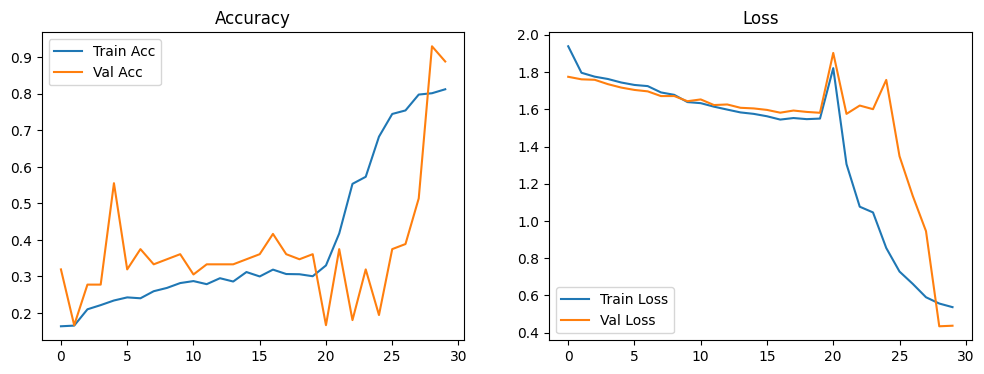

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

Step 6 : Testing the model performance

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step
              precision    recall  f1-score   support

     Crazing       0.85      0.92      0.88        12
   Inclusion       0.75      1.00      0.86        12
     Patches       1.00      0.75      0.86        12
      Pitted       0.64      0.58      0.61        12
      Rolled       0.71      0.83      0.77        12
   Scratches       1.00      0.75      0.86        12

    accuracy                           0.81        72
   macro avg       0.82      0.81      0.80        72
weighted avg       0.82      0.81      0.80        72



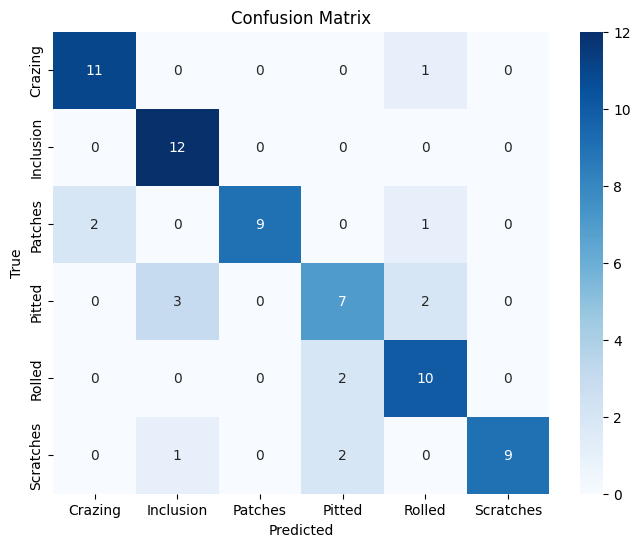

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
test_preds = model.predict(test_generator)
test_labels = test_generator.classes
test_preds_classes = np.argmax(test_preds, axis=1)

# Metrics
print(classification_report(test_labels, test_preds_classes, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()